In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.auto import tqdm, trange


from pandas_profiling import ProfileReport

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

In [2]:
raw_data1 = pd.read_csv("data/train01.csv", sep=";")
raw_data2 = pd.read_csv("data/train02.csv", sep=";")
test = pd.read_csv("data/test.csv", sep=";")

raw_data1["kind"] = "train"
raw_data2["kind"] = "val"

In [3]:
raw_data = pd.concat([raw_data1, raw_data2])

In [4]:
raw_data.loc[~raw_data["x2"].isnull(), "x2"] = raw_data.loc[~raw_data["x2"].isnull(), "x2"].apply(lambda x: datetime.strptime(x, "%d.%m.%Y").date())
test.loc[~test["x2"].isnull(), "x2"] = test.loc[~test["x2"].isnull(), "x2"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

In [5]:
def str2list(s, sep=None):
    return list(map(float, s[1:-1].split(sep)))


raw_data.drop(["x8", "x9"], axis=1, inplace=True)
test.drop(["x8", "x9"], axis=1, inplace=True)

# train.x8 = train.x8.apply(str2list)
# train.x9 = train.x9.apply(str2list)

for idx in trange(10, 43):
    raw_data[f"x{idx}"] = raw_data[f"x{idx}"].apply(lambda x: str2list(x, sep=", "))
    test[f"x{idx}"] = test[f"x{idx}"].apply(lambda x: str2list(x, sep=", "))

100%|██████████| 33/33 [00:12<00:00,  2.64it/s]


<BarContainer object of 41 artists>

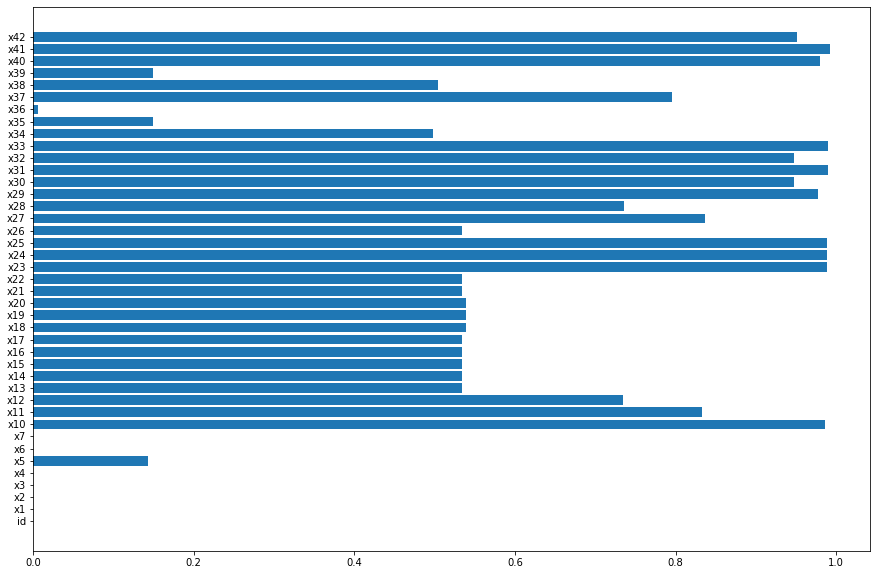

In [6]:
fig = plt.figure(figsize=(15, 10))

nans = {}
for col in raw_data.columns:
    if col == "y" or col == "kind":
        continue
    nans[col] = raw_data[col].explode().isnull().mean()

plt.barh(list(nans.keys()), list(nans.values()))

In [7]:
for key, value in nans.items():
    if value >= 0.6:
        raw_data.drop(key, axis=1, inplace=True)
        test.drop(key, axis=1, inplace=True)

In [8]:
raw_data

,id,y,x1,x2,x3,x4,x5,x6,x7,x13,...,x20,x21,x22,x26,x34,x35,x36,x38,x39,kind
0,-9196902500682081904,0,-2201458060675810556,2008-09-01,6312572492787112517,182,-6.347413e+18,2066976859146697559,0,"[nan, 1.0, nan, nan, 1.0, 1.0]",...,"[nan, 0.28, nan, nan, 0.0, 9969.07]","[nan, 0.0, nan, nan, 0.0, 0.0]","[nan, 0.0, nan, nan, 0.0, 0.0]","[nan, 0.0, nan, nan, 0.0, 0.0]","[3.0, 2.0, 1.0, nan, nan, 1.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[224.79, 224.79, 224.79, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]",train
1,-9196902500682081900,0,-2201458060675810556,2013-02-05,4293238556669161936,182,-8.465179e+18,-8648529837587014226,0,"[nan, nan, 0.0, 0.0, nan, 0.0]",...,"[nan, nan, 0.02, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[4.0, nan, nan, 2.0, 3.0, 7.0]","[90.27, 90.27, 90.27, 90.27, 90.27, 90.27]","[249.94, 249.94, 249.94, 249.94, 155.64, 155.64]","[nan, nan, nan, nan, nan, nan]","[103.09, 103.09, 103.09, 103.09, 103.09, 103.09]",train
2,-9196902500682081899,0,-2201458060675810556,2008-09-01,6312572492787112517,175,5.417474e+18,-5480331477604673780,1,"[nan, 0.0, nan, nan, nan, nan]",...,"[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan, 2.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[196.61, 224.79, 197.55, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]",train
3,-9196902500682081897,0,-2201458060675810556,2008-09-01,6312572492787112517,182,-6.347413e+18,-3150357754345161454,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[nan, nan, nan, 1.0, 2.0, 1.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[199.65, 199.65, 199.65, 199.65, 199.65, 199.65]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]",train
4,-9196902500681081897,0,-2201458060675810556,2008-09-01,6312572492787112517,179,6.856367e+18,4900304581511328621,2,"[nan, 0.0, nan, 0.0, nan, nan]",...,"[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[3.0, nan, 2.0, nan, 1.0, 5.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[224.79, 224.79, 224.79, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]",train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93184,9162040885608725764,0,-4849479253074186081,2011-12-21,6312572492787112517,167,7.599054e+18,2066976859146697559,1,"[0.0, 0.0, 0.0, 0.0, nan, nan]",...,"[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[3.0, nan, 3.0, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[149.36, 149.36, 149.36, 99.49, 149.36, 149.36]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]",val
93185,9162040885608725769,0,-4849479253074186081,2016-08-25,6312572492787112517,8,7.599054e+18,-2615825110734950454,0,"[nan, nan, nan, nan, nan, 0.0]",...,"[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[1.0, 1.0, nan, 1.0, 2.0, 2.0]","[nan, nan, nan, nan, nan, 67.64]","[61.35, 61.35, 61.35, 61.35, 61.35, 61.35]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, 80.46]",val
93186,9162040885608725770,0,-4849479253074186081,2013-12-02,6312572492787112517,184,7.599054e+18,2066976859146697559,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,"[0.35, 0.04, 0.04, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[2.0, nan, 2.0, nan, nan, 1.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[177.34, 176

In [9]:
def aggregate(df):
    for col in df.loc[:, "x13":].columns:
        if col == "kind":
            continue
        
        x = np.array(df[col].tolist())

        min_ = np.nanmin(x, axis=1, keepdims=True)
        max_ = np.nanmax(x, axis=1, keepdims=True)
        mean = np.nanmean(x, axis=1, keepdims=True)
        std = np.nanstd(x, axis=1, keepdims=True)
        p = np.isnan(x).mean(1, keepdims=True)

        x[np.isnan(x)] = -1

        x = np.hstack([x, min_, max_, mean, std, p])

        names = [f"{col}_{i}" for i in range(1, 7)] + \
                [f"{col}_min", f"{col}_max", f"{col}_mean", f"{col}_std", f"{col}_nans"]

        df[names] = x

        df.drop(col, axis=1, inplace=True)
        
        
def fill_null(df):
    df.loc[df["x2"].isnull(), "x2"] = datetime(1, 1, 1, 0, 0, 0).date()
    df.loc[df["x1"].isnull(), "x1"] = -1
    df.loc[df["x3"].isnull(), "x3"] = -1
    df.loc[df["x5"].isnull(), "x5"] = -1
    df.loc[df["x6"].isnull(), "x6"] = -1
    
    
def convert_str(df):
    df.x1 = df.x1.astype(str)
    df.x3 = df.x3.astype(str)
    df.x5 = df.x5.astype(str)
    df.x6 = df.x6.astype(str)
    

def convert_date(df):
    df['x2_month'] = df['x2'].apply(lambda x: x.month)
    df['x2_day'] = df['x2'].apply(lambda x: x.day)
    df.drop("x2", axis=1, inplace=True)

In [10]:
aggregate(raw_data)
aggregate(test)

/tmp/ipykernel_77261/536983447.py:8: RuntimeWarning: All-NaN slice encountered
  min_ = np.nanmin(x, axis=1, keepdims=True)
/tmp/ipykernel_77261/536983447.py:9: RuntimeWarning: All-NaN slice encountered
  max_ = np.nanmax(x, axis=1, keepdims=True)
/tmp/ipykernel_77261/536983447.py:10: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(x, axis=1, keepdims=True)
/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [11]:
fill_null(raw_data)
fill_null(test)

convert_str(raw_data)
convert_str(test)

convert_date(raw_data)
convert_date(test)

In [12]:
unique_ids = pd.unique(raw_data.id)
N = unique_ids.shape[0]

train_ids = np.random.choice(unique_ids, size=int(0.95 * N), replace=False)

train = raw_data[raw_data.id.isin(train_ids)].drop(["id", "y", "kind"], axis=1).copy().values
y_train = raw_data[raw_data.id.isin(train_ids)]["y"].copy().values

val = raw_data[~raw_data.id.isin(train_ids)].drop(["id", "y", "kind"], axis=1).copy().values
y_val = raw_data[~raw_data.id.isin(train_ids)]["y"].copy().values


# train = raw_data[raw_data.kind == "train"].drop(["id", "y", "kind"], axis=1).copy().values
# y_train = raw_data[raw_data.kind == "train"]["y"].copy().values

# val = raw_data[raw_data.kind == "val"].drop(["id", "y", "kind"], axis=1).copy().values
# y_val = raw_data[raw_data.kind == "val"]["y"].copy().values

In [13]:
cat = CatBoostClassifier(2000, task_type="GPU")

cat.fit(train, y_train, [0, 1, 2, 4, 5]);

Learning rate set to 0.013632
0:	learn: 0.6666591	total: 30.5ms	remaining: 1m 1s
1:	learn: 0.6407715	total: 53.4ms	remaining: 53.4s
2:	learn: 0.6158379	total: 76.7ms	remaining: 51.1s
3:	learn: 0.5925519	total: 104ms	remaining: 52s
4:	learn: 0.5701067	total: 130ms	remaining: 51.9s
5:	learn: 0.5497946	total: 156ms	remaining: 51.7s
6:	learn: 0.5293757	total: 179ms	remaining: 51s
7:	learn: 0.5112661	total: 201ms	remaining: 50.1s
8:	learn: 0.4927782	total: 223ms	remaining: 49.2s
9:	learn: 0.4755828	total: 243ms	remaining: 48.5s
10:	learn: 0.4589309	total: 267ms	remaining: 48.2s
11:	learn: 0.4427085	total: 288ms	remaining: 47.7s
12:	learn: 0.4272426	total: 309ms	remaining: 47.2s
13:	learn: 0.4126147	total: 329ms	remaining: 46.7s
14:	learn: 0.3986655	total: 349ms	remaining: 46.1s
15:	learn: 0.3854329	total: 371ms	remaining: 46s
16:	learn: 0.3727324	total: 392ms	remaining: 45.7s
17:	learn: 0.3607851	total: 414ms	remaining: 45.6s
18:	learn: 0.3493979	total: 435ms	remaining: 45.3s
19:	learn: 0.3

In [14]:
y_pred_proba = cat.predict_proba(val)
y_pred = cat.predict(val)

roc_auc_score(y_val, y_pred_proba[:, 1])

0.8919890561662083

In [15]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9074
           1       0.84      0.24      0.38       230

    accuracy                           0.98      9304
   macro avg       0.91      0.62      0.68      9304
weighted avg       0.98      0.98      0.97      9304



CROSS-VAL

In [16]:
# cat = CatBoostClassifier(task_type="GPU", cat_features=[0, 1, 2, 4, 5])
# scores = cross_val_score(cat, train, y_train, scoring="roc_auc")

In [17]:
# print(scores)
# print(np.mean(scores))

Train on whole dataset

In [18]:
train = raw_data.drop(["id", "y", "kind"], axis=1).copy().values
y_train = raw_data["y"].copy().values

In [19]:
cat = CatBoostClassifier(task_type="GPU")

cat.fit(train, y_train, [0, 1, 2, 4, 5]);

Learning rate set to 0.025297
0:	learn: 0.6436908	total: 22.2ms	remaining: 22.2s
1:	learn: 0.5984971	total: 40.8ms	remaining: 20.4s
2:	learn: 0.5583494	total: 61.5ms	remaining: 20.4s
3:	learn: 0.5218855	total: 80.7ms	remaining: 20.1s
4:	learn: 0.4867065	total: 99.8ms	remaining: 19.9s
5:	learn: 0.4557067	total: 119ms	remaining: 19.8s
6:	learn: 0.4262941	total: 138ms	remaining: 19.6s
7:	learn: 0.3998039	total: 157ms	remaining: 19.5s
8:	learn: 0.3754430	total: 178ms	remaining: 19.6s
9:	learn: 0.3531863	total: 198ms	remaining: 19.6s
10:	learn: 0.3330232	total: 216ms	remaining: 19.5s
11:	learn: 0.3146067	total: 236ms	remaining: 19.5s
12:	learn: 0.2977965	total: 255ms	remaining: 19.4s
13:	learn: 0.2825462	total: 276ms	remaining: 19.4s
14:	learn: 0.2682877	total: 296ms	remaining: 19.4s
15:	learn: 0.2554323	total: 317ms	remaining: 19.5s
16:	learn: 0.2436591	total: 334ms	remaining: 19.3s
17:	learn: 0.2329817	total: 351ms	remaining: 19.2s
18:	learn: 0.2231737	total: 370ms	remaining: 19.1s
19:	le

Submission

In [20]:
test_data = test.values
test_ids = test['id'] = test.index

In [21]:
y_test = cat.predict_proba(test_data)

In [22]:
submission = pd.DataFrame({
    "id": test_ids,
    "y": y_test[:, 1]
})

submission.to_csv("submission.csv", sep=";", index=False)

In [23]:
# from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
# from lightautoml.dataset.roles import DatetimeRole
# from lightautoml.tasks import Task
# from lightautoml.utils.profiler import Profiler

In [24]:
# tr_data = raw_data[raw_data.id.isin(train_ids)].copy()
# val = raw_data[~raw_data.id.isin(train_ids)].copy()

# roles = {
#     'target': 'y',
#     'drop': 'id'
# }

In [25]:
# task = Task('binary', metric=roc_auc_score)

In [26]:
# automl = TabularAutoML(task = task, 
#                        timeout = 600,
#                        cpu_limit = 4,
#                        general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned'], ['lgb_tuned', 'cb']]},
#                        reader_params = {'n_jobs': 4})

# oof_pred = automl.fit_predict(tr_data, roles=roles)

In [27]:
# test_pred = automl.predict(val)

# print('Check scores...')
# print('OOF score: {}'.format(roc_auc_score(tr_data['y'].values, oof_pred.data[:, 0])))
# print('TEST score: {}'.format(roc_auc_score(val['y'].values, test_pred.data[:, 0])))